# Car Insurance Analysis

Taking the freMTPL2 data set from [kaggle](https://www.kaggle.com/datasets/karansarpal/fremtpl2-french-motor-tpl-insurance-claims?resource=download&select=freMTPL2sev.csv), we will be creating a pricing model to price car insurance based on claims frequency and severity. The first approach will be to use a GLM.

This is an attempt to apply some ML algorithms to GI claims data in order to understand the various Python packages available for each technique and the syntax. 

## Import packages and the data

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns


## Reading the data

In [2]:
freqData = pd.read_csv("freMTPL2freq.csv")
sevData = pd.read_csv("freMTPL2sev.csv")

In [3]:
freqData = freqData.join(sevData, on = "IDpol", lsuffix = "_1")

Now let's explore the data by creating plots.

In [4]:
freqData.describe()

IDpol_1        ClaimNb       Exposure       VehPower  \
count  6.780130e+05  678013.000000  678013.000000  678013.000000   
mean   2.621857e+06       0.053247       0.528750       6.454631   
std    1.641783e+06       0.240117       0.364442       2.050906   
min    1.000000e+00       0.000000       0.002732       4.000000   
25%    1.157951e+06       0.000000       0.180000       5.000000   
50%    2.272152e+06       0.000000       0.490000       6.000000   
75%    4.046274e+06       0.000000       0.990000       7.000000   
max    6.114330e+06      16.000000       2.010000      15.000000   

              VehAge        DrivAge     BonusMalus        Density  \
count  678013.000000  678013.000000  678013.000000  678013.000000   
mean        7.044265      45.499122      59.761502    1792.422405   
std         5.666232      14.137444      15.636658    3958.646564   
min         0.000000      18.000000      50.000000       1.000000   
25%         2.000000      34.000000      50.000000      92.000000   
50%         6.000000      44.000000      50.000000     393.000000   
75%        11.000000      55.000000      64.000000    1658.000000   
max       100.000000     100.000000     230.000000   27000.000000   

              IDpol   ClaimAmount  
count  1.034600e+04  1.034600e+04  
mean   2.423575e+06  2.125582e+03  
std    1.706087e+06  1.526968e+04  
min    1.390000e+02  1.950000e+00  
25%    1.075404e+06  7.253625e+02  
50%    2.277846e+06  1.172000e+03  
75%    4.082571e+06  1.297553e+03  
max    6.113834e+06  1.301173e+06

## Initial Plots

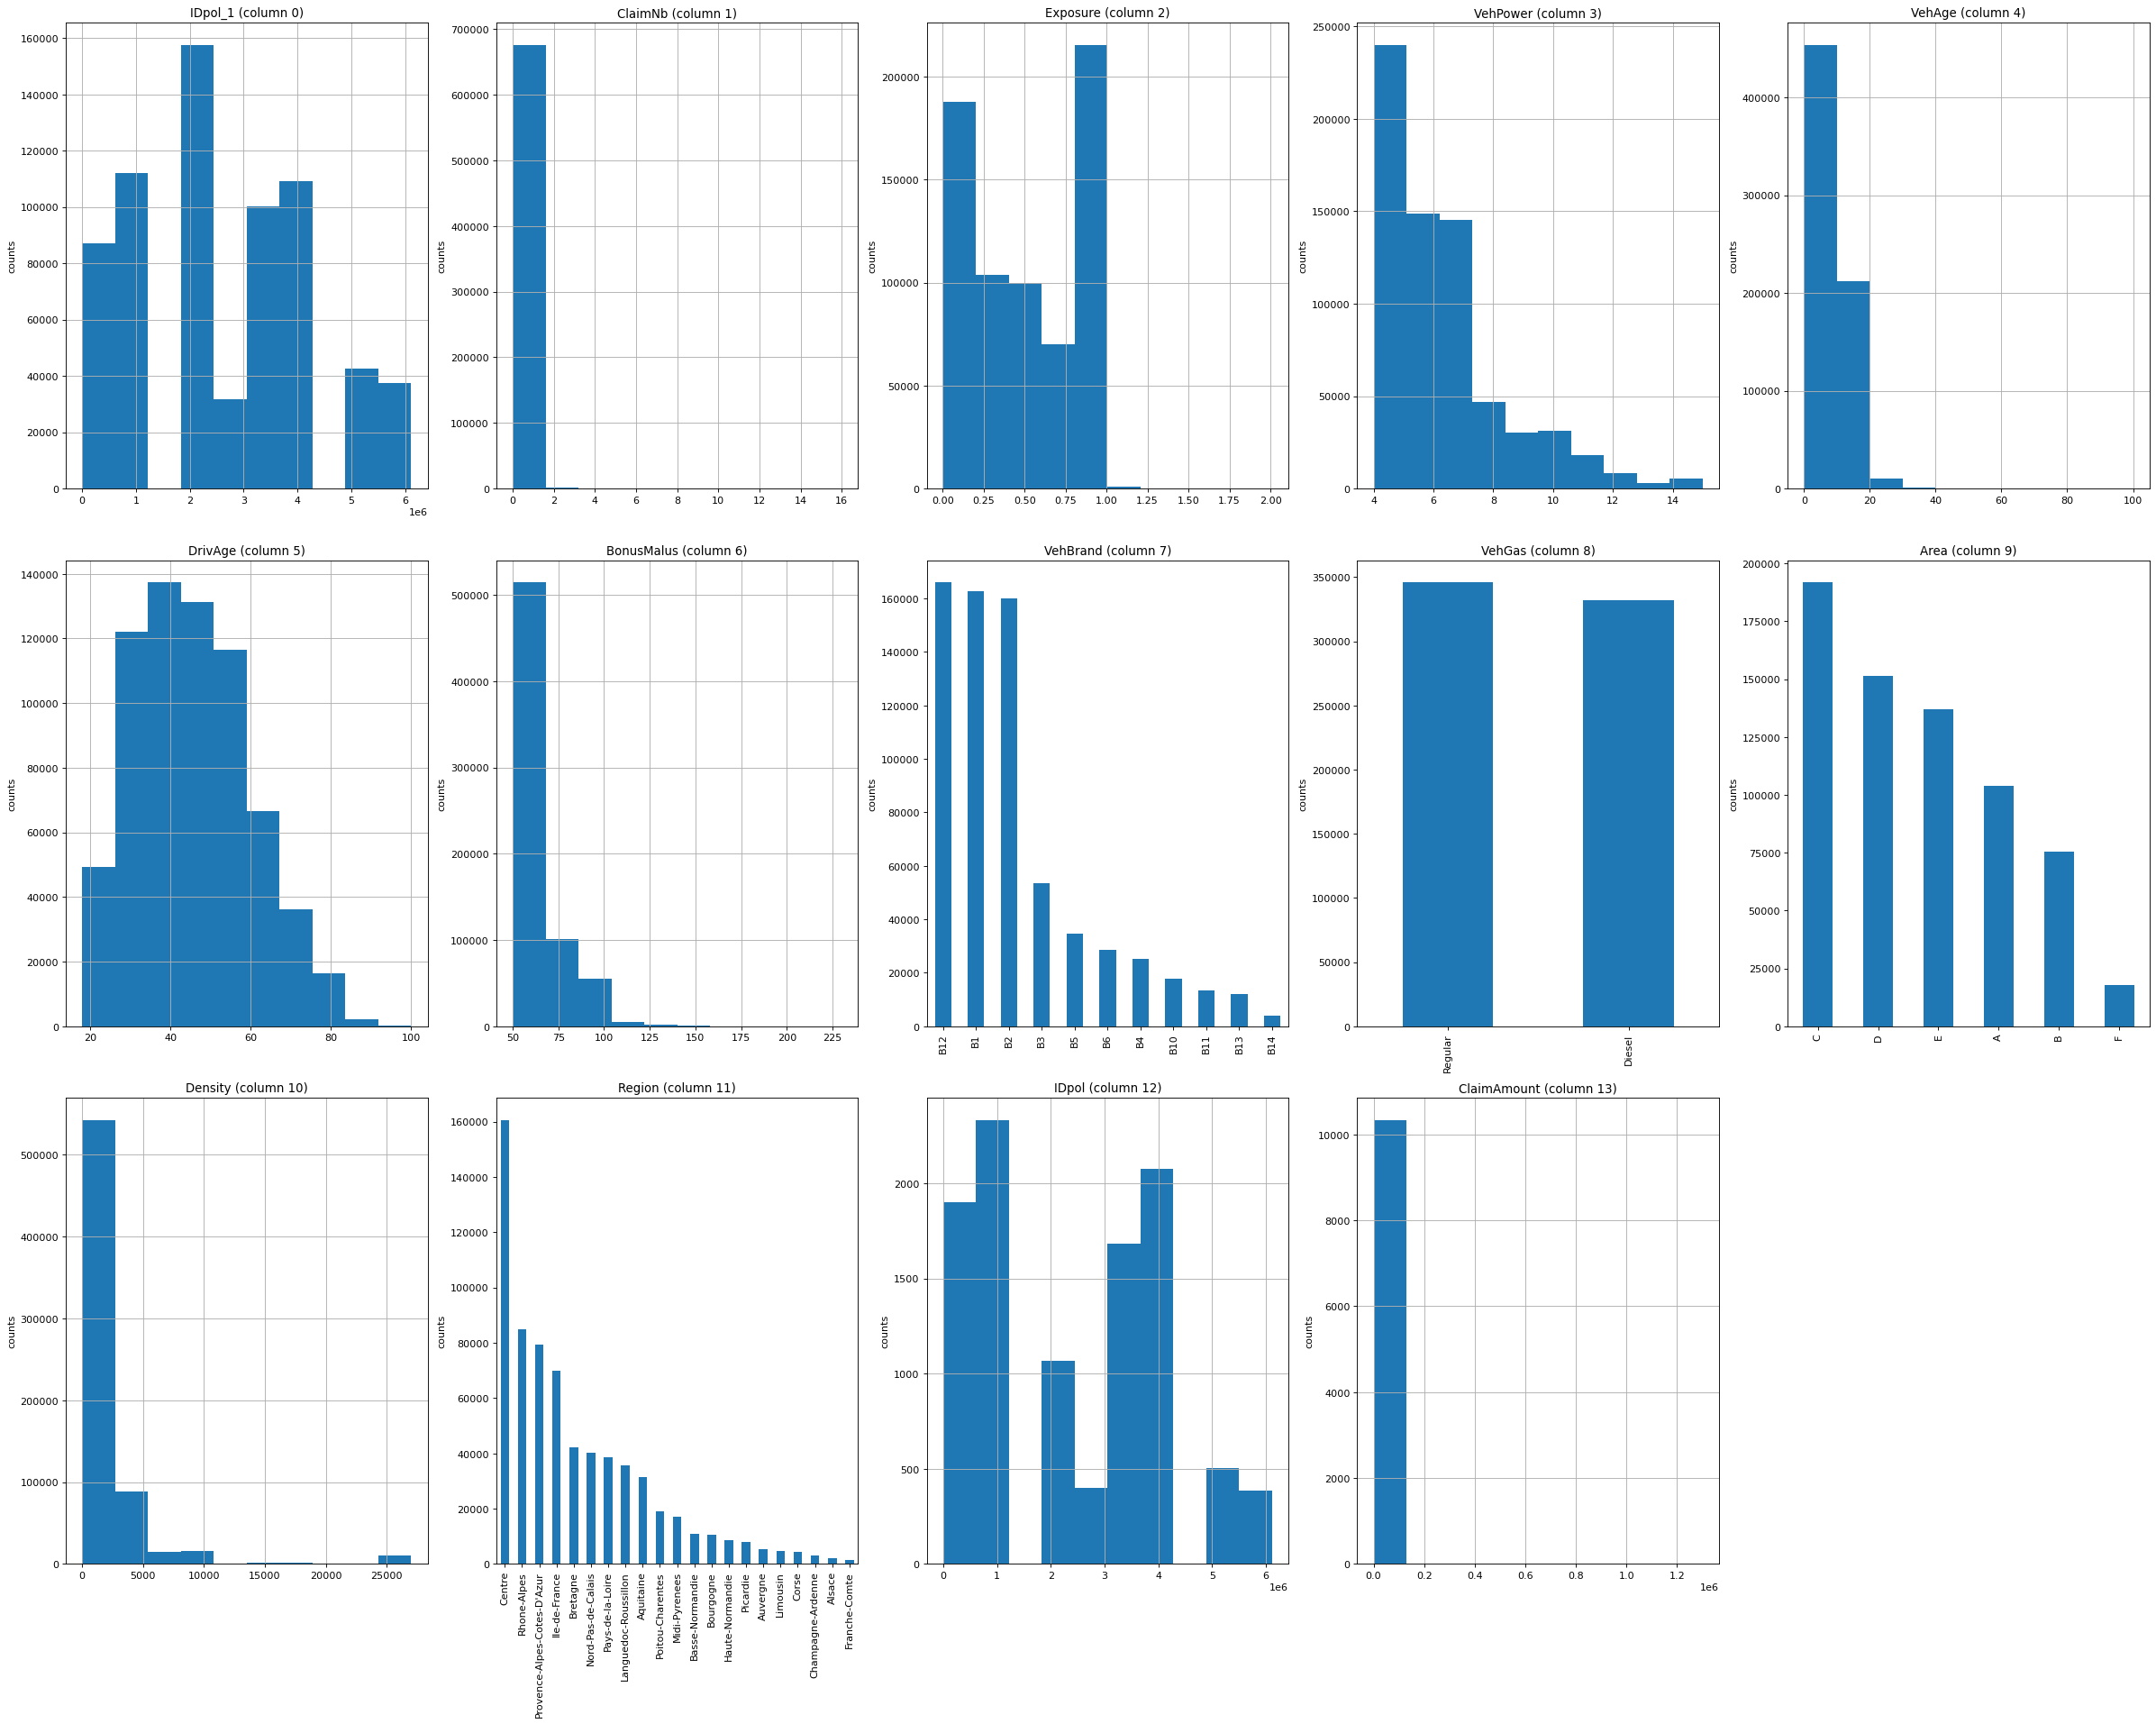

In [5]:
def createPlots (df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    nrow, ncol = df.shape
    columnNames = list(df)
    
    nGraphRow = int((ncol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    
    for i in range(min(ncol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if not(np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.title(f'{columnNames[i]} (column {i})')
    
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

createPlots(freqData, 15, 5)
            
    

As expected the claim amount is very heavily weighted around 0 as the majority of policies do not result in a claim. Now let's investigate the correlations between variables.

C:\Users\rrogers\AppData\Local\Temp\ipykernel_1652\2201160073.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN


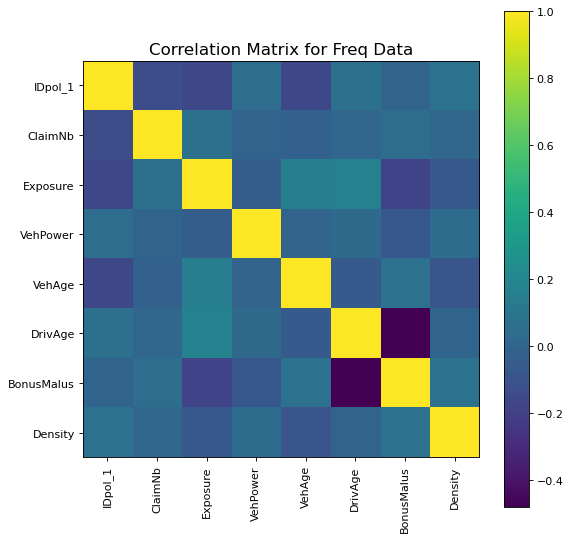

In [6]:
def createCorrelation(df):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]]
    
    if df.shape[1] < 2:
        print(f'Number of non-zero columns is less than 2, no correlations can be calculated')
        return
    
    correlation = df.corr()
    plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(correlation, fignum = 1)
    plt.xticks(range(len(correlation.columns)), correlation.columns, rotation=90)
    plt.yticks(range(len(correlation.columns)), correlation.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for Freq Data', fontsize=15)
    plt.show()
    
createCorrelation(freqData)

Noticable negative correlation between Drivers age and BonusMalus, BonusMalus over 100 mean an individual has __lost__ their bonus. So a negative correlation implies that older drivers have lower scores. This is as expected as younger drivers are involved in more accidents. Some positive correlation between Drivers age and Exposure implying that older drivers more hold their policies for their full duration compared to younger drivers. 

In [7]:
freqData.groupby(by = 'DrivAge').sum()

IDpol_1  ClaimNb     Exposure  VehPower  VehAge  BonusMalus  \
DrivAge                                                                     
18       1.592559e+09       65   210.709377      4373    7878       69571   
19       5.595495e+09      243   912.894303     13975   24836      229940   
20       8.379096e+09      335  1460.979158     21421   36792      350225   
21       1.013216e+10      353  1820.101138     25651   41199      414456   
22       1.261395e+10      430  2223.703357     30974   44860      482494   
...               ...      ...          ...       ...     ...         ...   
96       3.774912e+07        0    13.250000        94     174         794   
97       2.827462e+07        0     8.600000        65     122         540   
98       1.647107e+07        0     4.150000        31      57         250   
99       2.099304e+07        8    49.370000       475     536        3828   
100      1.612186e+07        0     1.730000        27       7         150   

         Density        IDpol  ClaimAmount  
DrivAge                                     
18        679423    5734445.0      4453.67  
19       2452841    8654812.0      4760.42  
20       4407593   60544604.0     57523.05  
21       5474454   94393223.0    200047.17  
22       7121465  188341536.0    209853.30  
...          ...          ...          ...  
96         44528          0.0         0.00  
97         36575          0.0         0.00  
98         35183          0.0         0.00  
99        112799   16617667.0      3465.49  
100          321          0.0         0.00  

[83 rows x 9 columns]

### Aggregate claims by policy ID

In [8]:
freqData = pd.read_csv("freMTPL2freq.csv")

In [9]:
print(sum(sevData['ClaimAmount']))

60697930.679998256


In [10]:
sevDataGroup = sevData.groupby('IDpol').sum('ClaimAmount').reset_index()

In [11]:
mergedData = freqData.merge(sevDataGroup, how = 'outer', on = 'IDpol').fillna(0).set_index('IDpol')

In [12]:
mergedData.dtypes

ClaimNb        float64
Exposure       float64
VehPower       float64
VehAge         float64
DrivAge        float64
BonusMalus     float64
VehBrand        object
VehGas          object
Area            object
Density        float64
Region          object
ClaimAmount    float64
dtype: object

In [13]:
noClaims = len(mergedData.loc[mergedData['ClaimAmount'] ==0])
claims = len(mergedData.loc[mergedData['ClaimAmount'] !=0])
print(f'There are {noClaims} policies with no claims and {claims} policies that made claims, meaning that {round(noClaims/(noClaims + claims) * 100,2)}% individuals haven\'t claimed')

There are 653069 policies with no claims and 24950 policies that made claims, meaning that 96.32% individuals haven't claimed


We now need to calculate the exposure adjusted claims and severity, fortunately we have exposure as a column.

In [14]:
mergedData['claimFreq'] = mergedData['ClaimNb'] / mergedData['Exposure']
mergedData['claimSev'] = mergedData['ClaimAmount'] / mergedData['Exposure']

For our investigation we should remove `ClaimAmount` and `ClaimSev` from the data as these are not known when a claim is made. We are wishing the predict the claim amount. Now we create y (predictor) and X (observations).

In [15]:
y_full = mergedData['ClaimAmount']
X_full = mergedData.drop(['ClaimAmount', 'claimSev'], axis = 1)

### Encoding the data
We need to encode the categorical variables to either One-hot or Label encoded. We'll use label encoding for 'Area' and one hot encoding for 'Region', 'VehGas', 'VehBrand'

In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [17]:
copy_X = X_full.copy()

le = LabelEncoder()

copy_X['Area'] = le.fit_transform(copy_X['Area'].astype('str'))


In [18]:
# Now apply OH encoding to the other categorical
OH_cols = ['Region', 'VehGas', 'VehBrand']

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Create OH arrays and then convert to DF
OH_data = pd.DataFrame(OH_encoder.fit_transform(copy_X[OH_cols].astype('str')))

#Add index back in
OH_data.index = copy_X.index

#Add labels back
OH_data.columns = OH_encoder.get_feature_names_out(OH_cols)

# Remove the original columns and merge with new columns
X_enc = pd.concat([copy_X.drop(OH_cols, axis=1), OH_data], axis=1)


Next we normalise the data so it lies between 0 and 1

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Initialise the MinMaxScaler model, then fit it to the (encoded) training feature dataset.
MM_scaler = MinMaxScaler()
MM_scaler.fit(X_enc)

# Fit the scaler, then normalise/transform both the training and validation feature datasets.
X_scaled = pd.DataFrame(MM_scaler.transform(X_enc), index = X_enc.index, columns = X_enc.columns)

X_scaled = X_scaled.fillna(0)


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_full, test_size=0.20, random_state=42)

## Fitting Random Forest, Poisson and Tweedie.
We will use 5-fold cross validation and BIC to assess the model fit.

In [22]:
# Import the RF regressor model
from sklearn.ensemble import RandomForestRegressor
# Import the cross_val_score function from sklearn.
from sklearn.model_selection import cross_val_score 

model_RF = RandomForestRegressor(n_estimators=100, random_state=1)

scores_RF = -1 * cross_val_score(model_RF, X_train, y_train,
                                 cv=5,
                                 scoring='neg_mean_absolute_error')


In [23]:
# Import poission regressor
from sklearn.linear_model import PoissonRegressor

model_PGLM = PoissonRegressor(alpha=1, max_iter=500)
    
scores_PGLM = -1 * cross_val_score(model_PGLM, X_train, y_train,
                                  cv=5,
                                  scoring='neg_mean_absolute_error')


In [27]:
# Import Tweedie regressor
from sklearn.linear_model import TweedieRegressor

model_TGLM = TweedieRegressor(power=1.8, alpha=1, max_iter=500)
    
scores_TGLM = -1 * cross_val_score(model_TGLM, X_train, y_train,
                                  cv=5,
                                  scoring='neg_mean_absolute_error')

In [28]:
# Import XGB
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score 

model_XGB = XGBRegressor(n_estimators=100,
                          learning_rate=0.01,
                          random_state=1)
    
scores_XGB = -1 * cross_val_score(model_XGB, X_train, y_train,
                                  cv=5,
                                  scoring='neg_mean_absolute_error')

In [30]:
print(scores_PGLM)
print(scores_RF)
print(scores_TGLM)
print(scores_XGB)

[166.63630775 166.7443776  197.81318172 161.54017611 173.91602662]
[110.59944689 117.92216457 138.83919232 128.48243033 158.96269304]
[167.4644736  167.18248575 199.17001652 162.04011655 174.7507941 ]
[ 77.82420351  82.08027636 113.77457106  82.48567225  96.05503048]


In [33]:
# Now we fit the models to the unscaled data
from sklearn.model_selection import train_test_split
X_enc = X_enc.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X_enc, y_full, test_size=0.20, random_state=42)

model_RF.fit(X_train, y_train)
print("model_RF_opt trained")

model_PGLM.fit(X_train, y_train)
print("model_PGLM_opt trained")

model_TGLM.fit(X_train, y_train)
print("model_TGLM_opt trained")

model_XGB.fit(X_train, y_train)
print("model_XGB_opt trained")

model_RF_opt trained


C:\Users\rrogers\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\rrogers\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: overflow encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\rrogers\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\rrogers\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:42: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\rrogers\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
C:\Users\rrogers\Anaconda3\lib\s

model_PGLM_opt trained


C:\Users\rrogers\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\rrogers\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: overflow encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\rrogers\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\rrogers\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:42: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\rrogers\Anaconda3\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\rrogers\Anaconda3\l

model_TGLM_opt trained
model_XGB_opt trained


In [34]:
# Now we do some predictions on the test data to predict the claim amounts

preds_RF = model_RF.predict(X_test)
preds_PGLM = model_PGLM.predict(X_test)
preds_TGLM = model_TGLM.predict(X_test)
preds_XGB = model_XGB.predict(X_test)
print("All predictions generated")

All predictions generated


In [37]:
# Assess the fit based on Mean Absolute Error rather than RSM
from sklearn.metrics import mean_absolute_error
MAE_RF = mean_absolute_error(y_test, preds_RF)
MAE_PGLM = mean_absolute_error(y_test, preds_PGLM)
MAE_TGLM = mean_absolute_error(y_test, preds_TGLM)
MAE_XGB = mean_absolute_error(y_test, preds_XGB)

In [39]:
print(MAE_RF)
print(MAE_PGLM)
print(MAE_TGLM)
print(MAE_XGB)


121.90569416999743
163.71898656531647
163.71898656531647
63.793389835684735
